In [ ]:
# Setup for Google Colab
# If you are running this on Google Colab, please follow these steps:
# 1. Enable GPU: Go to Runtime -> Change runtime type -> Hardware accelerator -> T4 GPU
# 2. Clone the repository to access data and utilities:
#    !git clone [YOUR_REPOSITORY_URL]
#    %cd [REPOSITORY_NAME]/notebooks
# 3. Install dependencies:

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    print("Running on Google Colab. Installing dependencies...")
    !pip install -q 'monai[nibabel, tqdm]'
    !pip install -q matplotlib pyyaml
    
    # Optional: Mount Drive if your data is on Google Drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    
    print("Dependencies installed.")
else:
    print("Running locally.")

import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Training will be very slow.")

<img src="./IMTA.png" alt="Logo IMT Atlantique" width="300"/>

##  **Frugal AI : Data Scarcity on Prostate MRI**
## TAF Health - UE B - 2025/2026 

Pierre-Henri.Conze@imt-atlantique.fr - Vincent.Jaouen@imt-atlantique.fr


In this lab, we will work with the **Prostate158** dataset (Mid-Axial slices). 
We want to understand the impact of **training data size** and **augmentation** on segmentation performance.

**Dataset**:
*   Images: T2-weighted MRI slices of the prostate-
*   Labels: Prostate segmentation masks.

**Plan:**
1.  **Setup**: Load `prostate158` dataset and define a fixed validation split.
2.  **Part I (Scarcity)**: Train specific U-Nets on very small subsets (e.g., 5, 10, 20 images) without augmentation.
3.  **Part II (Augmentation)**: Repeat the training on the smallest subsets using extensive Data Augmentation.
4.  **Analysis**: Compare learning curves and final Dice scores.

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))
import torch
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import yaml
from monai.data import CacheDataset, DataLoader
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityRangePercentilesd,
    RandFlipd, RandRotate90d, RandZoomd, RandShiftIntensityd, RandGaussianNoised,
    EnsureTyped, SpatialPadd, CenterSpatialCropd, Resized
)
from monai.utils import set_determinism

# Fix seed for reproducibility
set_determinism(seed=29200)

## 1. Data Loading

We will parse the `dataset.json` provided with the dataset to get image/label pairs.

In [2]:
# Configuration
data_dir = "../datasets/prostate158_MidAxial"
json_path = os.path.join(data_dir, "dataset.json")

# Load dataset.json
with open(json_path) as f:
    schema = json.load(f)

# Extract training paths (relative paths in JSON need to be joined with data_dir)
data_dicts = []
for entry in schema["training"]:
    # json entries: "./imagesTr/xxx.nii.gz"
    img_path = os.path.join(data_dir, entry["image"].replace("./", ""))
    lbl_path = os.path.join(data_dir, entry["label"].replace("./", ""))
    data_dicts.append({"image": img_path, "label": lbl_path})

print(f"Total available images: {len(data_dicts)}")

# Check one pair
print(f"Sample Image: {data_dicts[0]['image']}")

# Define Fixed Split (Last 30 for Validation)
val_size = 30
val_files = data_dicts[-val_size:]
train_pool = data_dicts[:-val_size]

print(f"Validation set size: {len(val_files)}")
print(f"Training pool size: {len(train_pool)}")

Total available images: 139
Sample Image: ../datasets/prostate158_MidAxial/imagesTr/020.nii.gz
Validation set size: 30
Training pool size: 109


## 2. Transforms Pipeline

We setup the MONAI transforms.
*   **Preprocessing**: Load, Channel First, Normalize Intensity (1st-99th percentile).
*   **Augmentation**: Flips, Rotation, Zoom, Intensity Shift (activated only if `augment=True`).

In [3]:
def get_transforms(augment=False):
    # Base Transforms
    transforms_list = [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"], channel_dim=-1), 
        Resized(keys=["image", "label"], spatial_size=(256, 256), mode=("bilinear", "nearest")),
        ScaleIntensityRangePercentilesd(
            keys="image", lower=1, upper=99, 
            b_min=0.0, b_max=1.0, clip=True
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
    
    # Augmentation
    if augment:
        transforms_list += [
            # Geometric
            # Vertical Flip (Axis 1) is anatomically more plausible than L/R or random rotation here
            RandFlipd(keys=["image", "label"], spatial_axis=1, prob=0.5), 
            RandZoomd(keys=["image", "label"], min_zoom=0.9, max_zoom=1.1, mode=["area", "nearest"], prob=0.3),
            
            # Intensity
            RandShiftIntensityd(keys=["image"], offsets=0.1, prob=0.5),
            RandGaussianNoised(keys=["image"], prob=0.1, mean=0.0, std=0.05),
        ]
        
    return Compose(transforms_list)

## 3. Experiment Runner

We reuse the configuration from `segmentation.yaml` but override channel settings.

In [4]:
from utils.training import train_segmentation
from utils.model_utils import model_factory
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

# Load Config
with open("../configs/segmentation.yaml") as f:
    cfg = yaml.safe_load(f)

# Override config for this dataset
cfg["data"]["data_dir"] = data_dir
cfg["model"]["in_channels"] = 1   # Single channel MRI
cfg["model"]["out_channels"] = 1  # Binary segmentation
cfg["training"]["max_epochs"] = 30  # Set global default duration

def run_experiment(n_train_samples, augment, max_epochs=None):
    # Use config value if max_epochs not provided
    if max_epochs is None:
        max_epochs = cfg["training"]["max_epochs"]

    print(f"\n{'='*40}")
    print(f"Running Experiment: N={n_train_samples}, Augmentation={augment}, Epochs={max_epochs}")
    print(f"{'='*40}")
    
    # 1. Deterministic Subset
    train_subset = train_pool[:n_train_samples]
    
    # 2. Dataloaders
    train_ds = CacheDataset(
        data=train_subset, 
        transform=get_transforms(augment=augment), 
        cache_rate=1.0, num_workers=2
    )
    val_ds = CacheDataset(
        data=val_files, 
        transform=get_transforms(augment=False), 
        cache_rate=1.0, num_workers=2
    )
    
    train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)
    
    # 3. Model Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_factory(cfg["model"]).to(device)
    loss_fn = DiceCELoss(sigmoid=True, to_onehot_y=False)
    dice_metric = DiceMetric(include_background=True, reduction="mean")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # 4. Training
    history = train_segmentation(
        model, train_loader, val_loader,
        loss_fn, dice_metric, optimizer,
        device=device, max_epochs=max_epochs,
        overlay_fn=None # Disable plotting during loop
    )
    
    return history, model

## 4. Part I: Scarcity Impact (No Augmentation)

Train with **5, 10, 40** images.

In [5]:
results_no_aug = {}
sample_sizes = [100,50,20]

for n in sample_sizes:
    # We use 50 epochs for a fair comparison with the augmentation part
    (train_losses, val_dices, best_dice, weights), _ = run_experiment(n, augment=False, max_epochs=50)
    results_no_aug[n] = val_dices
    print(f"-> Final Best Dice (N={n}, No Aug): {best_dice:.4f}")


Running Experiment: N=100, Augmentation=False, Epochs=50


Loading dataset: 100%|██████████| 30/30 [00:01<00:00, 15.77it/s]


Epoch 1/50


  Loss: 1.4384, Val Dice: 0.6404
Epoch 2/50


  Loss: 1.2718, Val Dice: 0.7600
Epoch 3/50


  Loss: 1.2177, Val Dice: 0.7752
Epoch 4/50


  Loss: 1.1622, Val Dice: 0.7904
Epoch 5/50


  Loss: 1.1181, Val Dice: 0.8204
Epoch 6/50


  Loss: 1.0721, Val Dice: 0.8046
Epoch 7/50


  Loss: 1.0309, Val Dice: 0.8109
Epoch 8/50


  Loss: 0.9983, Val Dice: 0.8201
Epoch 9/50


  Loss: 0.9459, Val Dice: 0.8249
Epoch 10/50


  Loss: 0.8956, Val Dice: 0.8197
Epoch 11/50


  Loss: 0.8460, Val Dice: 0.8143
Epoch 12/50


  Loss: 0.7926, Val Dice: 0.8377
Epoch 13/50


  Loss: 0.7468, Val Dice: 0.8342
Epoch 14/50


  Loss: 0.6970, Val Dice: 0.8439
Epoch 15/50


  Loss: 0.6559, Val Dice: 0.8382
Epoch 16/50


  Loss: 0.6078, Val Dice: 0.8439
Epoch 17/50


  Loss: 0.5655, Val Dice: 0.8449
Epoch 18/50


  Loss: 0.5225, Val Dice: 0.8582
Epoch 19/50


  Loss: 0.4880, Val Dice: 0.8536
Epoch 20/50


  Loss: 0.4640, Val Dice: 0.8422
Epoch 21/50


  Loss: 0.4346, Val Dice: 0.8418
Epoch 22/50


  Loss: 0.4070, Val Dice: 0.8640
Epoch 23/50


  Loss: 0.3566, Val Dice: 0.8602
Epoch 24/50


  Loss: 0.3335, Val Dice: 0.8575
Epoch 25/50


  Loss: 0.3016, Val Dice: 0.8656
Epoch 26/50


  Loss: 0.2736, Val Dice: 0.8727
Epoch 27/50


  Loss: 0.2450, Val Dice: 0.8740
Epoch 28/50


  Loss: 0.2191, Val Dice: 0.8800
Epoch 29/50


  Loss: 0.2015, Val Dice: 0.8673
Epoch 30/50


  Loss: 0.1926, Val Dice: 0.8775
Epoch 31/50


  Loss: 0.1864, Val Dice: 0.8550
Epoch 32/50


  Loss: 0.1773, Val Dice: 0.8735
Epoch 33/50


  Loss: 0.1641, Val Dice: 0.8713
Epoch 34/50


  Loss: 0.1644, Val Dice: 0.8666
Epoch 35/50


  Loss: 0.1533, Val Dice: 0.8768
Epoch 36/50


  Loss: 0.1451, Val Dice: 0.8733
Epoch 37/50


  Loss: 0.1340, Val Dice: 0.8688
Epoch 38/50


  Loss: 0.1224, Val Dice: 0.8796
Epoch 39/50


  Loss: 0.1103, Val Dice: 0.8807
Epoch 40/50


  Loss: 0.1028, Val Dice: 0.8823
Epoch 41/50


  Loss: 0.0950, Val Dice: 0.8823
Epoch 42/50


  Loss: 0.0883, Val Dice: 0.8776
Epoch 43/50


  Loss: 0.0834, Val Dice: 0.8825
Epoch 44/50


  Loss: 0.0798, Val Dice: 0.8771
Epoch 45/50


  Loss: 0.0778, Val Dice: 0.8770
Epoch 46/50


  Loss: 0.0740, Val Dice: 0.8816
Epoch 47/50


  Loss: 0.0739, Val Dice: 0.8763
Epoch 48/50


  Loss: 0.0729, Val Dice: 0.8780
Epoch 49/50


  Loss: 0.0680, Val Dice: 0.8769
Epoch 50/50


  Loss: 0.0652, Val Dice: 0.8770
-> Final Best Dice (N=100, No Aug): 0.8825

Running Experiment: N=50, Augmentation=False, Epochs=50


Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 132.24it/s]


Epoch 1/50


  Loss: 1.6087, Val Dice: 0.2591
Epoch 2/50


  Loss: 1.4819, Val Dice: 0.2593
Epoch 3/50


  Loss: 1.4329, Val Dice: 0.2607
Epoch 4/50


  Loss: 1.3974, Val Dice: 0.2717
Epoch 5/50


  Loss: 1.3822, Val Dice: 0.2917
Epoch 6/50


  Loss: 1.3500, Val Dice: 0.3547
Epoch 7/50


  Loss: 1.3305, Val Dice: 0.4464
Epoch 8/50


  Loss: 1.2988, Val Dice: 0.5961
Epoch 9/50


  Loss: 1.2822, Val Dice: 0.6900
Epoch 10/50


  Loss: 1.2453, Val Dice: 0.7393
Epoch 11/50


  Loss: 1.2338, Val Dice: 0.7610
Epoch 12/50


  Loss: 1.2008, Val Dice: 0.7679
Epoch 13/50


  Loss: 1.1781, Val Dice: 0.7824
Epoch 14/50


  Loss: 1.1538, Val Dice: 0.7821
Epoch 15/50


  Loss: 1.1224, Val Dice: 0.8114
Epoch 16/50


  Loss: 1.0954, Val Dice: 0.8060
Epoch 17/50


  Loss: 1.0663, Val Dice: 0.7993
Epoch 18/50


  Loss: 1.0379, Val Dice: 0.8045
Epoch 19/50


  Loss: 1.0145, Val Dice: 0.7923
Epoch 20/50


  Loss: 0.9900, Val Dice: 0.8059
Epoch 21/50


  Loss: 0.9463, Val Dice: 0.7991
Epoch 22/50


  Loss: 0.9282, Val Dice: 0.8064
Epoch 23/50


  Loss: 0.8912, Val Dice: 0.8157
Epoch 24/50


  Loss: 0.8672, Val Dice: 0.8111
Epoch 25/50


  Loss: 0.8301, Val Dice: 0.8224
Epoch 26/50


  Loss: 0.8074, Val Dice: 0.8188
Epoch 27/50


  Loss: 0.7719, Val Dice: 0.8245
Epoch 28/50


  Loss: 0.7448, Val Dice: 0.8123
Epoch 29/50


  Loss: 0.7174, Val Dice: 0.8180
Epoch 30/50


  Loss: 0.6968, Val Dice: 0.8140
Epoch 31/50


  Loss: 0.6720, Val Dice: 0.8130
Epoch 32/50


  Loss: 0.6579, Val Dice: 0.8219
Epoch 33/50


  Loss: 0.6109, Val Dice: 0.8157
Epoch 34/50


  Loss: 0.6123, Val Dice: 0.8043
Epoch 35/50


  Loss: 0.5842, Val Dice: 0.8107
Epoch 36/50


  Loss: 0.5679, Val Dice: 0.7948
Epoch 37/50


  Loss: 0.5584, Val Dice: 0.8095
Epoch 38/50


  Loss: 0.5504, Val Dice: 0.8199
Epoch 39/50


  Loss: 0.5293, Val Dice: 0.6386
Epoch 40/50


  Loss: 0.5707, Val Dice: 0.8279
Epoch 41/50


  Loss: 0.5428, Val Dice: 0.8148
Epoch 42/50


  Loss: 0.4807, Val Dice: 0.8123
Epoch 43/50


  Loss: 0.4432, Val Dice: 0.8258
Epoch 44/50


  Loss: 0.4068, Val Dice: 0.8296
Epoch 45/50


  Loss: 0.3827, Val Dice: 0.8336
Epoch 46/50


  Loss: 0.3603, Val Dice: 0.8309
Epoch 47/50


  Loss: 0.3399, Val Dice: 0.8330
Epoch 48/50


  Loss: 0.3285, Val Dice: 0.8329
Epoch 49/50


  Loss: 0.3118, Val Dice: 0.8330
Epoch 50/50


  Loss: 0.2986, Val Dice: 0.8329
-> Final Best Dice (N=50, No Aug): 0.8336

Running Experiment: N=20, Augmentation=False, Epochs=50


Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 107.31it/s]


Epoch 1/50


  Loss: 1.7175, Val Dice: 0.2627
Epoch 2/50


  Loss: 1.5615, Val Dice: 0.2628
Epoch 3/50


  Loss: 1.4699, Val Dice: 0.2592
Epoch 4/50


  Loss: 1.4555, Val Dice: 0.2594
Epoch 5/50


  Loss: 1.4218, Val Dice: 0.2574
Epoch 6/50


  Loss: 1.4253, Val Dice: 0.2585
Epoch 7/50


  Loss: 1.3897, Val Dice: 0.2588
Epoch 8/50


  Loss: 1.3702, Val Dice: 0.2617
Epoch 9/50


  Loss: 1.3568, Val Dice: 0.2672
Epoch 10/50


  Loss: 1.3398, Val Dice: 0.2701
Epoch 11/50


  Loss: 1.3274, Val Dice: 0.2814
Epoch 12/50


  Loss: 1.3147, Val Dice: 0.3013
Epoch 13/50


  Loss: 1.3024, Val Dice: 0.3179
Epoch 14/50


  Loss: 1.2912, Val Dice: 0.3400
Epoch 15/50


  Loss: 1.2821, Val Dice: 0.3721
Epoch 16/50


  Loss: 1.2761, Val Dice: 0.4362
Epoch 17/50


  Loss: 1.2645, Val Dice: 0.4418
Epoch 18/50


  Loss: 1.2515, Val Dice: 0.5194
Epoch 19/50


  Loss: 1.2416, Val Dice: 0.5542
Epoch 20/50


  Loss: 1.2326, Val Dice: 0.5838
Epoch 21/50


  Loss: 1.2234, Val Dice: 0.6090
Epoch 22/50


  Loss: 1.2134, Val Dice: 0.6457
Epoch 23/50


  Loss: 1.2028, Val Dice: 0.6321
Epoch 24/50


  Loss: 1.1945, Val Dice: 0.6554
Epoch 25/50


  Loss: 1.1883, Val Dice: 0.6635
Epoch 26/50


  Loss: 1.1768, Val Dice: 0.6430
Epoch 27/50


  Loss: 1.1686, Val Dice: 0.6442
Epoch 28/50


  Loss: 1.1548, Val Dice: 0.6610
Epoch 29/50


  Loss: 1.1439, Val Dice: 0.6829
Epoch 30/50


  Loss: 1.1331, Val Dice: 0.6780
Epoch 31/50


  Loss: 1.1211, Val Dice: 0.6702
Epoch 32/50


  Loss: 1.1099, Val Dice: 0.6810
Epoch 33/50


  Loss: 1.0997, Val Dice: 0.6868
Epoch 34/50


  Loss: 1.0890, Val Dice: 0.6996
Epoch 35/50


  Loss: 1.0784, Val Dice: 0.6794
Epoch 36/50


  Loss: 1.0674, Val Dice: 0.6959
Epoch 37/50


  Loss: 1.0585, Val Dice: 0.6899
Epoch 38/50


  Loss: 1.0470, Val Dice: 0.6954
Epoch 39/50


  Loss: 1.0360, Val Dice: 0.7029
Epoch 40/50


  Loss: 1.0251, Val Dice: 0.6871
Epoch 41/50


  Loss: 1.0143, Val Dice: 0.6925
Epoch 42/50


  Loss: 1.0039, Val Dice: 0.7027
Epoch 43/50


  Loss: 0.9929, Val Dice: 0.6980
Epoch 44/50


  Loss: 0.9835, Val Dice: 0.6998
Epoch 45/50


  Loss: 0.9736, Val Dice: 0.6909
Epoch 46/50


  Loss: 0.9637, Val Dice: 0.7079
Epoch 47/50


  Loss: 0.9538, Val Dice: 0.6976
Epoch 48/50


  Loss: 0.9424, Val Dice: 0.6874
Epoch 49/50


  Loss: 0.9312, Val Dice: 0.6957
Epoch 50/50


  Loss: 0.9203, Val Dice: 0.6979
-> Final Best Dice (N=20, No Aug): 0.7079


## 5. Part II: Mitigation via Augmentation 

Train with **5, 10** images using **Augmentation**.

In [6]:
results_aug = {}
aug_sample_sizes = [50,20]

for n in aug_sample_sizes:
    (train_losses, val_dices, best_dice, weights), _ = run_experiment(n, augment=True)
    results_aug[n] = val_dices
    print(f"-> Final Best Dice (N={n}, Aug): {best_dice:.4f}")


Running Experiment: N=50, Augmentation=True, Epochs=30


Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 138.48it/s]


Epoch 1/30


  Loss: 1.4197, Val Dice: 0.5208
Epoch 2/30


  Loss: 1.2952, Val Dice: 0.6999
Epoch 3/30


  Loss: 1.2272, Val Dice: 0.6616
Epoch 4/30


  Loss: 1.2011, Val Dice: 0.7710
Epoch 5/30


  Loss: 1.1479, Val Dice: 0.7765
Epoch 6/30


  Loss: 1.1332, Val Dice: 0.7829
Epoch 7/30


  Loss: 1.1243, Val Dice: 0.7764
Epoch 8/30


  Loss: 1.1010, Val Dice: 0.7892
Epoch 9/30


  Loss: 1.0754, Val Dice: 0.7693
Epoch 10/30


  Loss: 1.0455, Val Dice: 0.7910
Epoch 11/30


  Loss: 1.0197, Val Dice: 0.7882
Epoch 12/30


  Loss: 1.0040, Val Dice: 0.7770
Epoch 13/30


  Loss: 0.9963, Val Dice: 0.8192
Epoch 14/30


  Loss: 0.9766, Val Dice: 0.8038
Epoch 15/30


  Loss: 0.9642, Val Dice: 0.7948
Epoch 16/30


  Loss: 0.9520, Val Dice: 0.7925
Epoch 17/30


  Loss: 0.9274, Val Dice: 0.8017
Epoch 18/30


  Loss: 0.8982, Val Dice: 0.8324
Epoch 19/30


  Loss: 0.8727, Val Dice: 0.8359
Epoch 20/30


  Loss: 0.8541, Val Dice: 0.8471
Epoch 21/30


  Loss: 0.8361, Val Dice: 0.8434
Epoch 22/30


  Loss: 0.8005, Val Dice: 0.8497
Epoch 23/30


  Loss: 0.7781, Val Dice: 0.8537
Epoch 24/30


  Loss: 0.7568, Val Dice: 0.8595
Epoch 25/30


  Loss: 0.7291, Val Dice: 0.8621
Epoch 26/30


  Loss: 0.7154, Val Dice: 0.8575
Epoch 27/30


  Loss: 0.7098, Val Dice: 0.8537
Epoch 28/30


  Loss: 0.6792, Val Dice: 0.8495
Epoch 29/30


  Loss: 0.6757, Val Dice: 0.8594
Epoch 30/30


  Loss: 0.6417, Val Dice: 0.8650
-> Final Best Dice (N=50, Aug): 0.8650

Running Experiment: N=20, Augmentation=True, Epochs=30


Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 132.41it/s]


Epoch 1/30


  Loss: 1.7318, Val Dice: 0.2991
Epoch 2/30


  Loss: 1.5600, Val Dice: 0.3033
Epoch 3/30


  Loss: 1.5873, Val Dice: 0.3383
Epoch 4/30


  Loss: 1.4512, Val Dice: 0.3912
Epoch 5/30


  Loss: 1.3954, Val Dice: 0.4879
Epoch 6/30


  Loss: 1.3445, Val Dice: 0.6152
Epoch 7/30


  Loss: 1.3424, Val Dice: 0.6736
Epoch 8/30


  Loss: 1.3235, Val Dice: 0.7015
Epoch 9/30


  Loss: 1.2776, Val Dice: 0.6508
Epoch 10/30


  Loss: 1.2950, Val Dice: 0.7036
Epoch 11/30


  Loss: 1.2441, Val Dice: 0.7125
Epoch 12/30


  Loss: 1.2545, Val Dice: 0.7325
Epoch 13/30


  Loss: 1.2345, Val Dice: 0.7389
Epoch 14/30


  Loss: 1.2121, Val Dice: 0.7176
Epoch 15/30


  Loss: 1.2004, Val Dice: 0.7233
Epoch 16/30


  Loss: 1.2011, Val Dice: 0.7321
Epoch 17/30


  Loss: 1.1492, Val Dice: 0.6886
Epoch 18/30


  Loss: 1.1512, Val Dice: 0.7516
Epoch 19/30


  Loss: 1.1440, Val Dice: 0.7306
Epoch 20/30


  Loss: 1.1365, Val Dice: 0.7388
Epoch 21/30


  Loss: 1.1109, Val Dice: 0.7680
Epoch 22/30


  Loss: 1.0960, Val Dice: 0.7575
Epoch 23/30


  Loss: 1.1057, Val Dice: 0.7593
Epoch 24/30


  Loss: 1.1181, Val Dice: 0.7613
Epoch 25/30


  Loss: 1.0812, Val Dice: 0.7564
Epoch 26/30


  Loss: 1.0658, Val Dice: 0.7744
Epoch 27/30


  Loss: 1.0432, Val Dice: 0.7549
Epoch 28/30


  Loss: 1.0471, Val Dice: 0.7357
Epoch 29/30


  Loss: 1.0412, Val Dice: 0.7590
Epoch 30/30


  Loss: 1.0232, Val Dice: 0.7803
-> Final Best Dice (N=20, Aug): 0.7803


## 6. Analysis and Visualization

Compare the validation Dice curves.

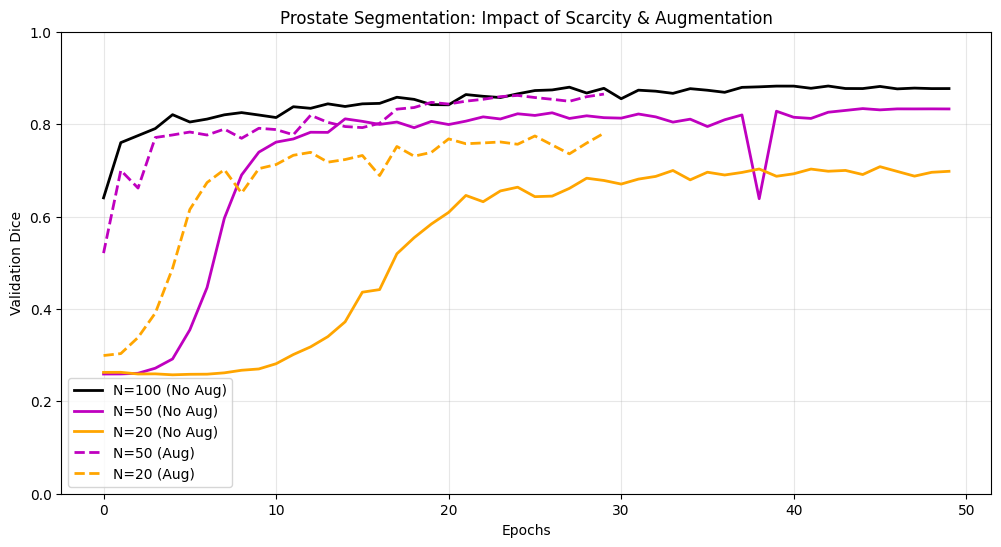

In [7]:
plt.figure(figsize=(12, 6))

colors = {5: 'r', 10: 'g', 20: 'orange', 40: 'b', 50: 'm', 100: 'k'} # Adjusted colors

# Plot No Aug
for n, dices in results_no_aug.items():
    c = colors.get(n, 'gray') # Gray fallback if size not in dict
    plt.plot(dices, label=f'N={n} (No Aug)', color=c, linestyle='-', linewidth=2)

# Plot Aug
for n, dices in results_aug.items():
    c = colors.get(n, 'gray')
    plt.plot(dices, label=f'N={n} (Aug)', color=c, linestyle='--', linewidth=2)

plt.title("Prostate Segmentation: Impact of Scarcity & Augmentation")
plt.xlabel("Epochs")
plt.ylabel("Validation Dice")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0)
plt.show()


## 7. Part III: Semi-Supervised Learning (Student-Teacher)

We simulate a scenario where we have **100 images** available, but only **50 are labeled**.
Can we leverage the 50 "unlabeled" images to improve the performance of a model trained on only 50 labeled examples?

**Strategy (Self-Training / Pseudo-Labeling):**
1.  **Train Teacher**: Use the 50 labeled images to train a model (Teacher).
2.  **Generate Pseudo-Labels**: Use the Teacher to predict segmentation masks for the 50 unlabeled images.
3.  **Train Student**: Train a new model (Student) on the **combined dataset** (50 Labeled + 50 Pseudo-Labeled).
4.  **Compare**: Student performance vs. Teacher (N=50) vs. Oracle (N=100 Labeled).


In [8]:
from monai.transforms import SaveImaged
from monai.inferers import sliding_window_inference
import nibabel as nib
from monai.transforms import Resize
import shutil

# --- Experiment Configuration ---
n_labeled = 50       # Number of Ground Truth images to use
n_unlabeled = 50     # Number of additional images to pseudo-label
ssl_epochs = 50      # Training epochs for both Teacher and Student

print(f"Configuration: {n_labeled} Labeled, {n_unlabeled} Unlabeled, {ssl_epochs} Epochs")

Configuration: 50 Labeled, 50 Unlabeled, 50 Epochs


### 7.1. Train the Teacher
We start by training a "Teacher" model on the available labeled data (e.g., 50 images). This follows the standard supervised training procedure.

In [9]:
print(f"--- Step 1: Training Teacher (N={n_labeled}) ---")

# Train Teacher using the existing experiment runner
# We store the results to compare later
(teacher_losses, teacher_dices, teacher_best_dice, teacher_weights), teacher_model = run_experiment(n_labeled, augment=True, max_epochs=ssl_epochs)

print(f"Teacher Best Validation Dice: {teacher_best_dice:.4f}")

--- Step 1: Training Teacher (N=50) ---

Running Experiment: N=50, Augmentation=True, Epochs=50


Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 144.37it/s]


Epoch 1/50


  Loss: 1.6061, Val Dice: 0.2743
Epoch 2/50


  Loss: 1.5072, Val Dice: 0.2896
Epoch 3/50


  Loss: 1.4646, Val Dice: 0.2911
Epoch 4/50


  Loss: 1.4313, Val Dice: 0.3339
Epoch 5/50


  Loss: 1.4112, Val Dice: 0.4175
Epoch 6/50


  Loss: 1.3814, Val Dice: 0.5047
Epoch 7/50


  Loss: 1.3625, Val Dice: 0.6423
Epoch 8/50


  Loss: 1.3254, Val Dice: 0.6824
Epoch 9/50


  Loss: 1.3200, Val Dice: 0.7499
Epoch 10/50


  Loss: 1.3111, Val Dice: 0.7521
Epoch 11/50


  Loss: 1.2692, Val Dice: 0.7408
Epoch 12/50


  Loss: 1.2484, Val Dice: 0.7407
Epoch 13/50


  Loss: 1.2417, Val Dice: 0.8033
Epoch 14/50


  Loss: 1.1924, Val Dice: 0.8000
Epoch 15/50


  Loss: 1.1657, Val Dice: 0.7414
Epoch 16/50


  Loss: 1.1596, Val Dice: 0.7950
Epoch 17/50


  Loss: 1.1218, Val Dice: 0.8093
Epoch 18/50


  Loss: 1.0980, Val Dice: 0.8046
Epoch 19/50


  Loss: 1.0792, Val Dice: 0.8011
Epoch 20/50


  Loss: 1.0616, Val Dice: 0.7466
Epoch 21/50


  Loss: 1.0154, Val Dice: 0.8220
Epoch 22/50


  Loss: 0.9959, Val Dice: 0.8213
Epoch 23/50


  Loss: 0.9604, Val Dice: 0.8253
Epoch 24/50


  Loss: 0.9348, Val Dice: 0.8286
Epoch 25/50


  Loss: 0.9158, Val Dice: 0.8241
Epoch 26/50


  Loss: 0.8967, Val Dice: 0.8067
Epoch 27/50


  Loss: 0.8735, Val Dice: 0.8218
Epoch 28/50


  Loss: 0.8366, Val Dice: 0.8359
Epoch 29/50


  Loss: 0.8001, Val Dice: 0.8302
Epoch 30/50


  Loss: 0.7758, Val Dice: 0.8526
Epoch 31/50


  Loss: 0.7439, Val Dice: 0.8695
Epoch 32/50


  Loss: 0.7223, Val Dice: 0.8436
Epoch 33/50


  Loss: 0.7001, Val Dice: 0.8557
Epoch 34/50


  Loss: 0.6825, Val Dice: 0.8379
Epoch 35/50


  Loss: 0.6511, Val Dice: 0.8491
Epoch 36/50


  Loss: 0.6414, Val Dice: 0.8502
Epoch 37/50


  Loss: 0.6044, Val Dice: 0.8616
Epoch 38/50


  Loss: 0.5733, Val Dice: 0.8575
Epoch 39/50


  Loss: 0.5535, Val Dice: 0.8639
Epoch 40/50


  Loss: 0.5396, Val Dice: 0.8629
Epoch 41/50


  Loss: 0.5152, Val Dice: 0.8669
Epoch 42/50


  Loss: 0.4943, Val Dice: 0.8582
Epoch 43/50


  Loss: 0.4828, Val Dice: 0.8689
Epoch 44/50


  Loss: 0.4744, Val Dice: 0.8749
Epoch 45/50


  Loss: 0.4614, Val Dice: 0.8542
Epoch 46/50


  Loss: 0.4725, Val Dice: 0.8713
Epoch 47/50


  Loss: 0.4273, Val Dice: 0.8565
Epoch 48/50


  Loss: 0.4406, Val Dice: 0.8220
Epoch 49/50


  Loss: 0.4502, Val Dice: 0.8560
Epoch 50/50


  Loss: 0.3931, Val Dice: 0.8898
Teacher Best Validation Dice: 0.8898


### 7.2. Generate Pseudo-Labels
Now that we have a trained Teacher, we use it to predict segmentation masks for the "unlabeled" images. These predictions serve as "Pseudo-Labels" for the Student.

**Crucial Step**: We must ensure the generated pseudo-labels match the exact file structure (dimensions, spacing) of the original data so they can be loaded correctly later. This involves:
1. Predicting inference masks (which are usually 256x256 due to our transforms).
2. Resizing them *back* to the original image native resolution (e.g., 270x270).
3. Ensuring the NIfTI file format (3D vs 2D dimensions) matches the source inputs exactly.

In [10]:
print(f"--- Step 2: Generating Pseudo-Labels for {n_unlabeled} images ---")

# 1. Prepare Teacher for Inference
teacher_model.load_state_dict(teacher_weights)
teacher_model.eval()

# 2. Select Unlabeled Data
# We select the images *immediately following* the labeled set in our training pool to simulate unlabeled data.
unlabeled_start = n_labeled
unlabeled_end = min(n_labeled + n_unlabeled, len(train_pool))
unlabeled_data = train_pool[unlabeled_start:unlabeled_end]

print(f"Generating labels for images {unlabeled_start} to {unlabeled_end}...")

# 3. Setup Output Directory
pseudo_label_dir = os.path.join(data_dir, "pseudo_labels")
if os.path.exists(pseudo_label_dir):
    shutil.rmtree(pseudo_label_dir) # Ensure a clean start
os.makedirs(pseudo_label_dir, exist_ok=True)

pseudo_labeled_data = []
infer_transforms = get_transforms(augment=False) # No augmentation for inference

# 4. Inference Loop
with torch.no_grad():
    for i, item in enumerate(unlabeled_data):
        # A. Load and Preprocess
        # Create a dictionary item to reuse the existing transform pipeline
        temp_item = {"image": item["image"], "label": item["image"]} 
        input_data = infer_transforms(temp_item)
        input_tensor = input_data["image"].unsqueeze(0).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
        
        # B. Predict (Teacher)
        outputs = teacher_model(input_tensor)
        outputs = torch.sigmoid(outputs)
        start_mask = (outputs > 0.5).float().cpu().numpy()[0, 0] # Threshold to binary mask
        
        # C. Post-process & Save
        # Resizing the prediction (256x256) back to the original native resolution (e.g., 270x270).
        orig_img = nib.load(item["image"])
        full_shape = orig_img.shape
        spatial_shape = full_shape[:2] if len(full_shape) == 3 else full_shape
        
        # Resize to native resolution
        resizer = Resize(spatial_size=spatial_shape, mode="nearest")
        mask_tensor_in = torch.from_numpy(start_mask).unsqueeze(0)
        mask_tensor_out = resizer(mask_tensor_in) 
        final_mask = mask_tensor_out.squeeze(0).numpy()
        
        # Correct dimensions to match original NIfTI file (handle 2D vs 3D differences)
        if len(full_shape) == 3 and full_shape[2] == 1:
            final_mask = final_mask[:, :, np.newaxis]
            
        # Save pseudo-label as a NIfTI file
        pseudo_filename = f"pseudo_{os.path.basename(item['image'])}"
        pseudo_path = os.path.join(pseudo_label_dir, pseudo_filename)
        nib.save(nib.Nifti1Image(final_mask.astype(np.float32), orig_img.affine), pseudo_path)
        
        pseudo_labeled_data.append({"image": item["image"], "label": pseudo_path})

print(f"Generated {len(pseudo_labeled_data)} pseudo-labels in {pseudo_label_dir}")

--- Step 2: Generating Pseudo-Labels for 50 images ---
Generating labels for images 50 to 100...
Generated 50 pseudo-labels in ../datasets/prostate158_MidAxial/pseudo_labels


### 7.3. Train the Student
The Student model is trained on the **Combined Dataset**:
1.  **Labeled Data**: The original 50 Ground Truth examples.
2.  **Pseudo-Labeled Data**: The 50 examples labeled by the Teacher.

We generally use **Strong Augmentation** for the student to encourage it to learn robust features and smooth out the noise from the imperfect pseudo-labels. In this lab, we simply reuse the `augment=True` pipeline.

In [11]:
print(f"--- Step 3: Training Student (N={len(pseudo_labeled_data) + n_labeled}) ---")

# 1. Combine Datasets
labeled_data = train_pool[:n_labeled]
combined_data = labeled_data + pseudo_labeled_data

print(f"Student Data: {len(labeled_data)} Gold Standard + {len(pseudo_labeled_data)} Pseudo-Labeled")

# 2. Define Loaders
# Validation uses the SAME fixed validation set as always
val_ds_student = CacheDataset(
    data=val_files, 
    transform=get_transforms(augment=False), 
    cache_rate=1.0, num_workers=2
)
val_loader_student = DataLoader(val_ds_student, batch_size=1, shuffle=False, num_workers=2)

# Student Training Set
student_ds = CacheDataset(
    data=combined_data, 
    transform=get_transforms(augment=True), 
    cache_rate=1.0, num_workers=2
)
student_loader = DataLoader(student_ds, batch_size=4, shuffle=True, num_workers=2)

# 3. Initialize Student Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = model_factory(cfg["model"]).to(device)
loss_fn = DiceCELoss(sigmoid=True, to_onehot_y=False)
dice_metric = DiceMetric(include_background=True, reduction="mean")
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-3)

# 4. Train
(student_losses, student_dices, student_best_dice, student_weights) = train_segmentation(
    student_model, student_loader, val_loader_student,
    loss_fn, dice_metric, optimizer,
    device=device, max_epochs=ssl_epochs,
    overlay_fn=None
)

print(f"Student Best Validation Dice: {student_best_dice:.4f}")

--- Step 3: Training Student (N=100) ---
Student Data: 50 Gold Standard + 50 Pseudo-Labeled


Loading dataset: 100%|██████████| 100/100 [00:00<00:00, 152.92it/s]


Epoch 1/50


  Loss: 1.3959, Val Dice: 0.5530
Epoch 2/50


  Loss: 1.2703, Val Dice: 0.6593
Epoch 3/50


  Loss: 1.1826, Val Dice: 0.7291
Epoch 4/50


  Loss: 1.1064, Val Dice: 0.7007
Epoch 5/50


  Loss: 1.0485, Val Dice: 0.7069
Epoch 6/50


  Loss: 0.9761, Val Dice: 0.7875
Epoch 7/50


  Loss: 0.9167, Val Dice: 0.7693
Epoch 8/50


  Loss: 0.8885, Val Dice: 0.7816
Epoch 9/50


  Loss: 0.8301, Val Dice: 0.8150
Epoch 10/50


  Loss: 0.7797, Val Dice: 0.8209
Epoch 11/50


  Loss: 0.7414, Val Dice: 0.8300
Epoch 12/50


  Loss: 0.7067, Val Dice: 0.8227
Epoch 13/50


  Loss: 0.6766, Val Dice: 0.8446
Epoch 14/50


  Loss: 0.6383, Val Dice: 0.8434
Epoch 15/50


  Loss: 0.6240, Val Dice: 0.8491
Epoch 16/50


  Loss: 0.5943, Val Dice: 0.8605
Epoch 17/50


  Loss: 0.5623, Val Dice: 0.8529
Epoch 18/50


  Loss: 0.5393, Val Dice: 0.8658
Epoch 19/50


  Loss: 0.5091, Val Dice: 0.8442
Epoch 20/50


  Loss: 0.4921, Val Dice: 0.8602
Epoch 21/50


  Loss: 0.4774, Val Dice: 0.8621
Epoch 22/50


  Loss: 0.4559, Val Dice: 0.8693
Epoch 23/50


  Loss: 0.4205, Val Dice: 0.8729
Epoch 24/50


  Loss: 0.4104, Val Dice: 0.8560
Epoch 25/50


  Loss: 0.3984, Val Dice: 0.8909
Epoch 26/50


  Loss: 0.3743, Val Dice: 0.8740
Epoch 27/50


  Loss: 0.3581, Val Dice: 0.8852
Epoch 28/50


  Loss: 0.3466, Val Dice: 0.8809
Epoch 29/50


  Loss: 0.3271, Val Dice: 0.8767
Epoch 30/50


  Loss: 0.3191, Val Dice: 0.8647
Epoch 31/50


  Loss: 0.3145, Val Dice: 0.8793
Epoch 32/50


  Loss: 0.2971, Val Dice: 0.8831
Epoch 33/50


  Loss: 0.2795, Val Dice: 0.8864
Epoch 34/50


  Loss: 0.2751, Val Dice: 0.8721
Epoch 35/50


  Loss: 0.2613, Val Dice: 0.8844
Epoch 36/50


  Loss: 0.2512, Val Dice: 0.8939
Epoch 37/50


  Loss: 0.2376, Val Dice: 0.8966
Epoch 38/50


  Loss: 0.2273, Val Dice: 0.8996
Epoch 39/50


  Loss: 0.2275, Val Dice: 0.8934
Epoch 40/50


  Loss: 0.2306, Val Dice: 0.8986
Epoch 41/50


  Loss: 0.2126, Val Dice: 0.8931
Epoch 42/50


  Loss: 0.2138, Val Dice: 0.8862
Epoch 43/50


  Loss: 0.2023, Val Dice: 0.8900
Epoch 44/50


  Loss: 0.1973, Val Dice: 0.8969
Epoch 45/50


  Loss: 0.1846, Val Dice: 0.9025
Epoch 46/50


  Loss: 0.1763, Val Dice: 0.8933
Epoch 47/50


  Loss: 0.1739, Val Dice: 0.8841
Epoch 48/50


  Loss: 0.1664, Val Dice: 0.8894
Epoch 49/50


  Loss: 0.1706, Val Dice: 0.9073
Epoch 50/50


  Loss: 0.1687, Val Dice: 0.9014
Student Best Validation Dice: 0.9073


### 7.4. Analysis
We compare the Validation Dice curves of the Teacher (trained on only labeled data) and the Student (trained on labeled + pseudo-labeled data).

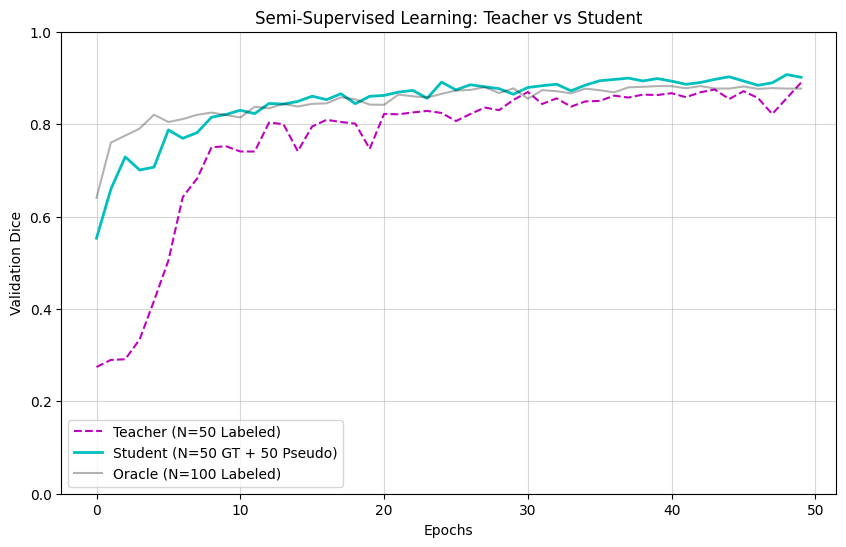

In [12]:
plt.figure(figsize=(10, 6))

# Teacher
plt.plot(teacher_dices, label=f'Teacher (N={n_labeled} Labeled)', color='m', linestyle='--')

# Student
plt.plot(student_dices, label=f'Student (N={n_labeled} GT + {n_unlabeled} Pseudo)', color='c', linewidth=2)

# Oracle Baseline (if available from previous steps)
if 'results_aug' in globals() and 100 in results_aug:
     plt.plot(results_aug[100], label='Oracle (N=100 Labeled)', color='k', alpha=0.3)
elif 'results_no_aug' in globals() and 100 in results_no_aug:
     plt.plot(results_no_aug[100], label='Oracle (N=100 Labeled)', color='k', alpha=0.3)

plt.title("Semi-Supervised Learning: Teacher vs Student")
plt.xlabel("Epochs")
plt.ylabel("Validation Dice")
plt.legend()
plt.grid(True, alpha=0.5)
plt.ylim(0, 1.0)
plt.show()